In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
fire_df = pd.read_csv("data/fire_data_checkpoint.csv")
fire_df.head(3)

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance
0,1964,COYOTE (4),65338.877636,Wildfire,381.341881
1,1964,C. HANLY (5),55960.694158,Wildfire,91.248279
2,1964,COZY DELL (5),19218.105903,Wildfire,447.055720


In [3]:
len(fire_df)

117190

## Create fire smoke estimates


Create an annual estimate of wildfire smoke in Chico. Technically, smoke impact should probably be considered the health, tourism, economic or other social problems that result from the smoke. For this we'll generically call your estimate the wildfire smoke impact. We will consider other potential social and economic impacts during Part 2 of this course project. 

For now, we only have access to fire area, distance to Chico, and fire type. 

We need some kind of number to represent an estimate of the smoke Chico saw during each annual fire season.


In [4]:
start_year = 1964
end_year = 2024

# fitler to last 60 years
filtered_fire_df = fire_df[(fire_df['Fire_Year'] >= start_year) & (fire_df['Fire_Year'] <= end_year)]

# filter to within 650 miles of Chico
filtered_fire_df['Distance'] = pd.to_numeric(filtered_fire_df['Distance'])
filtered_fire_df = filtered_fire_df[filtered_fire_df['Distance'] <= 650]

filtered_fire_df.head()

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance
0,1964,COYOTE (4),65338.877636,Wildfire,381.341881
1,1964,C. HANLY (5),55960.694158,Wildfire,91.248279
2,1964,COZY DELL (5),19218.105903,Wildfire,447.055720
3,1964,HAYFORK HWY. #2 (5),18712.494746,Wildfire,83.819785
4,1964,MATTOLE (5),16887.001024,Wildfire,133.471471


In [5]:
len(filtered_fire_df)

55153

### Priority Scores Based on Fire Type 

We assigned priority scores based on the potential impact on smoke emissions based on the ranking of `Fire_Type`.

- Wildfire: Highest priority (1) Fully known impact, significant smoke emissions
- Likely Wildfire: High priority (2) A high probability of being a wildfire, likely resulting in substantial emissions
- Unknown - Likely Wildfire: Medium priority (3) High potential for emissions
- Prescribed Fire: Lower priority (4) Lower emissions
- Unknown - Likely Prescribed Fire: Lowest priority (5) Uncertain classification, typically implies a lower potential for emissions.

### Calculation Logic

Fire types that are expected to produce more smoke will contribute more heavily to the smoke estimate.

The smoke estimate is calculated as:


$$
\text{smoke_estimate} = \frac{\text{area_burned} \times \text{fire_type_weight}}{\text{distance}^2}
$$

- `area_burned`: The area affected by the fire (acres).
- `fire_type_weight`: A numerical weight assigned based on the fire type's priority score (1 to 5).
- `distance`: The distance from Chico to the fire (miles).

In [6]:

def calculate_smoke_estimate(row):
    """
    A function for calculating smoke estimate for each wild fire.
    """
    
    # These fire type ranking weights help quantify the contribution of each fire type to the smoke estimate. 
    # The higher the weight, the greater the anticipated smoke emissions from that fire type. 
    fire_type_ranking = {
        'Wildfire': 1.0,  
        'Likely Wildfire': 0.8,
        'Unknown - Likely Wildfire': 0.6,
        'Prescribed Fire': 0.4,
        'Unknown - Likely Prescribed Fire': 0.2,  
    }
    
    area_burned = row['GIS_Acres'] 
    fire_type = row['Fire_Type']  
    distance = row['Distance']
    
    fire_type_weight = fire_type_ranking.get(fire_type, 0)  # default is 0 if fire type not found
    
    smoke_estimate = (area_burned * fire_type_weight) / (distance ** 2)

    return smoke_estimate




In [7]:
# apply the function to create a smoke_estimate column 

filtered_fire_df['Smoke_Estimates'] = filtered_fire_df.apply(
    lambda x: calculate_smoke_estimate(x), axis=1)

filtered_fire_df.head()

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance,Smoke_Estimates
0,1964,COYOTE (4),65338.877636,Wildfire,381.341881,0.449306
1,1964,C. HANLY (5),55960.694158,Wildfire,91.248279,6.720997
2,1964,COZY DELL (5),19218.105903,Wildfire,447.055720,0.096158
3,1964,HAYFORK HWY. #2 (5),18712.494746,Wildfire,83.819785,2.663414
4,1964,MATTOLE (5),16887.001024,Wildfire,133.471471,0.947929


## Visualizations

1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

- The estimate only considers the last 60 years of wildland fire data (1961-2021).
- The estimate only considers fires that are within 650 miles of your assigned city.
- Defines the annual fire season as running from May 1st through October 31st.


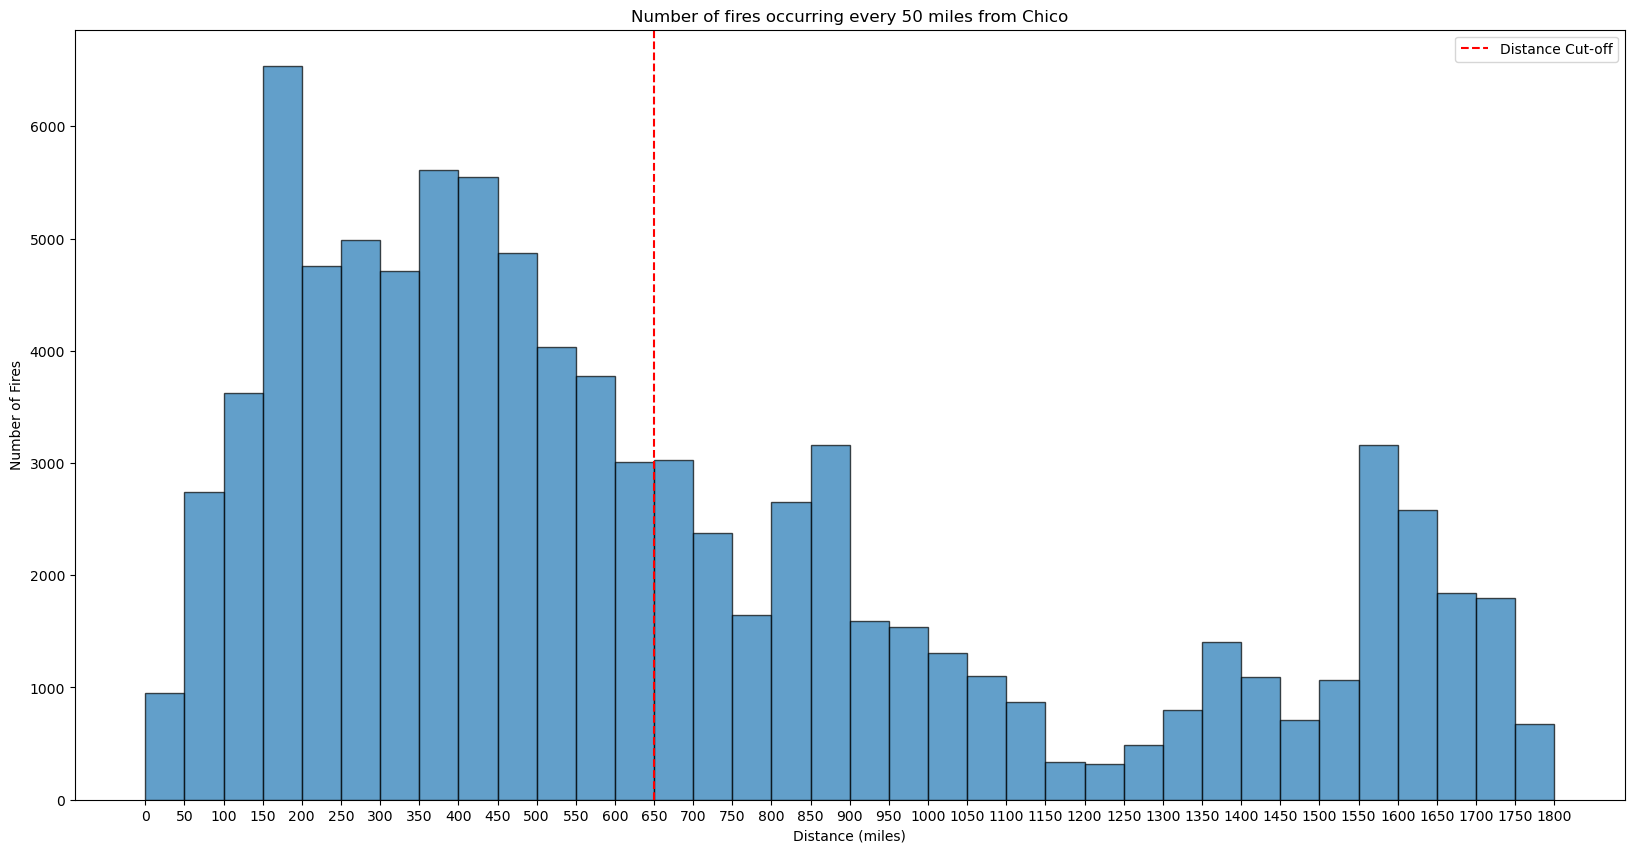

In [12]:
start_year = 1964
end_year = 2024
distance_cutoff = 1800
bin_width = 50

# fitler to last 60 years
filtered_fire_df_1 = fire_df[(fire_df['Fire_Year'] >= start_year) & (fire_df['Fire_Year'] <= end_year)]

# filter to within 1800 miles of Chico
filtered_fire_df_1['Distance'] = pd.to_numeric(filtered_fire_df_1['Distance'])
filtered_fire_df_1 = filtered_fire_df_1[filtered_fire_df_1['Distance'] <= distance_cutoff]


bins = range(0, distance_cutoff + bin_width, bin_width)

plt.figure(figsize=(20, 10))
plt.hist(filtered_fire_df_1['Distance'], bins=bins, edgecolor='black', alpha=0.7)
plt.title('Number of fires occurring every 50 miles from Chico')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.axvline(x=650, color='r', linestyle='--', label='Distance Cut-off')
plt.legend()
plt.xticks(bins)
plt.show()

2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from Chico.


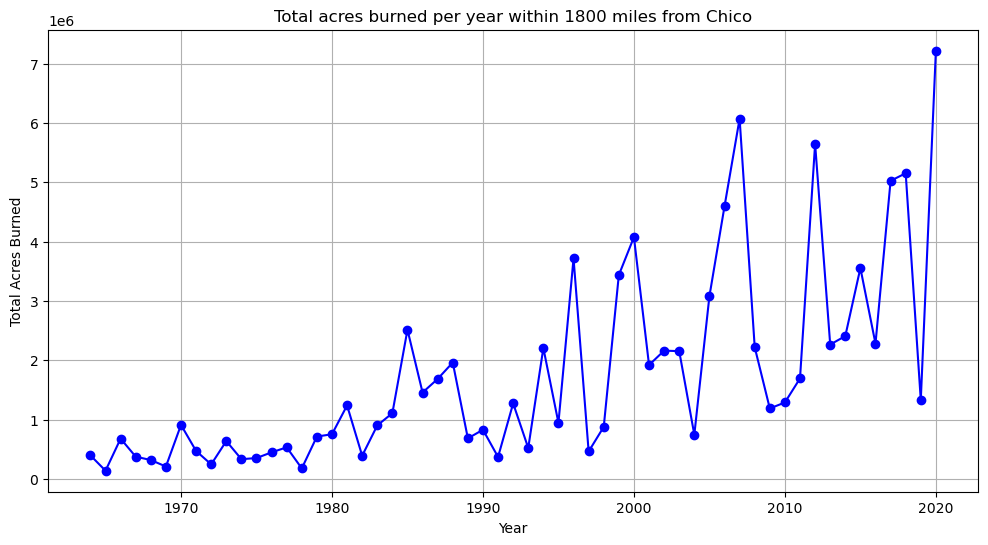

In [9]:
annual_acres_burned = filtered_fire_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(annual_acres_burned['Fire_Year'], annual_acres_burned['GIS_Acres'], marker='o', color='b', linestyle='-')
plt.title("Total acres burned per year within 1800 miles from Chico")
plt.xlabel("Year")
plt.ylabel("Total Acres Burned")
plt.grid(True)
plt.show()

3. Produce a time series graph containing your fire smoke estimates for Chico and the AQI estimates for your city.


In [36]:
# combine gas_df, part_df, calculate average AQI of gas_df and part_df

gas_df = pd.read_csv('data/gaseous_pollutants_data.csv')
part_df = pd.read_csv('data/particulate_pollutants_data.csv')

# data from monitoring station site: San Andreas-Gold Strike Road

gas_df_daily = gas_df.copy()
gas_df_daily['date_local'] = pd.to_datetime(gas_df['date_local'])
gas_df_daily['year'] = gas_df_daily['date_local'].dt.year

gas_df_daily = gas_df_daily.dropna(subset=['aqi']).reset_index(drop=True)

gas_df_daily = gas_df_daily[['aqi', 'year', 'date_local']]


gas_df_daily = gas_df_daily.groupby('date_local', as_index=False).agg({
    'aqi': 'mean',
    'year': 'first'
})


gas_df_yearly = gas_df_daily[['aqi', 'year']]

gas_df_yearly = gas_df_daily.groupby('year', as_index=False).agg({
    'aqi': 'mean'
})



part_df_daily = part_df.copy()
part_df_daily['date_local'] = pd.to_datetime(part_df['date_local'])
part_df_daily['year'] = part_df_daily['date_local'].dt.year

part_df_daily = part_df_daily.dropna(subset=['aqi']).reset_index(drop=True)

part_df_daily = part_df_daily[['aqi', 'year', 'date_local']]


part_df_daily = part_df_daily.groupby('date_local', as_index=False).agg({
    'aqi': 'mean',
    'year': 'first'
})

part_df_yearly = part_df_daily[['aqi', 'year']]

part_df_yearly = part_df_daily.groupby('year', as_index=False).agg({
    'aqi': 'mean'
})

# join gas_df_yearly with part_df_yearly on year, get an average aqi

merge_df = gas_df_yearly.merge(part_df_yearly, on='year')

merge_df['average_aqi'] = merge_df[['aqi_x', 'aqi_y']].mean(axis=1)


aqi_df = merge_df[['year', 'average_aqi']]
aqi_df.head(3)

,year,average_aqi
0,1994,49.978173
1,1995,42.183073
2,1996,43.394336


In [67]:
smoke_estimates_yearly = filtered_fire_df.groupby('Fire_Year', as_index=False).agg({
    'Smoke_Estimates': 'mean'  
})
smoke_estimates_yearly.rename(columns={'Fire_Year': 'year', 'Smoke_Estimates': 'average_smoke_estimate'}, inplace=True)

combined_df = aqi_df.merge(smoke_estimates_yearly, on='year', how='inner')
combined_df.head(3)

,year,average_aqi,average_smoke_estimate
0,1994,49.978173,0.111655
1,1995,42.183073,0.026152
2,1996,43.394336,0.056540


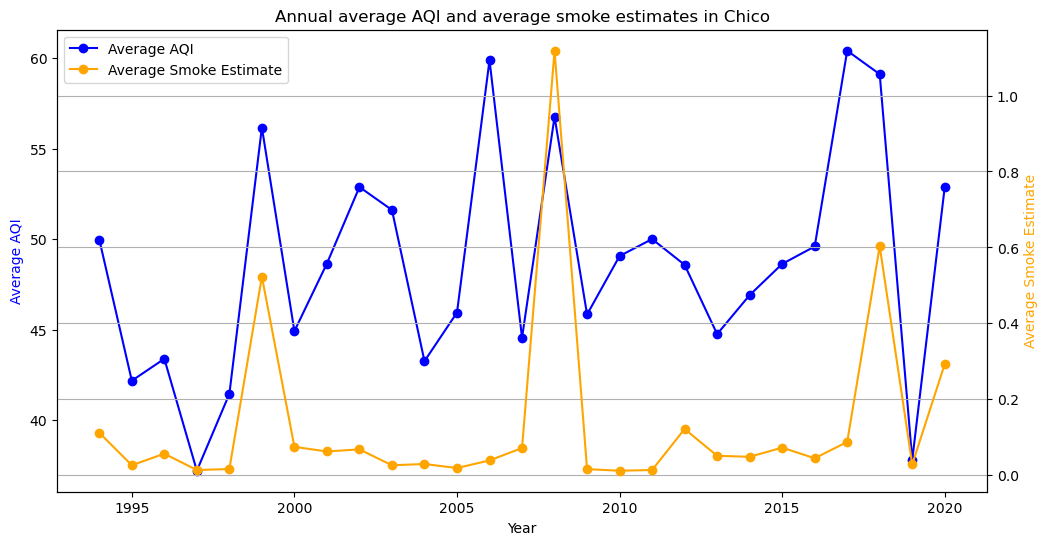

In [68]:
plt.figure(figsize=(12, 6))
aqi_line, = plt.plot(combined_df['year'], combined_df['average_aqi'], marker='o', linestyle='-', label='Average AQI', color='blue')
plt.ylabel('Average AQI', color='blue')
plt.xlabel('Year')

# second y-axis for smoke estimates
ax2 = plt.gca().twinx() 
smoke_line, = ax2.plot(combined_df['year'], combined_df['average_smoke_estimate'], marker='o', linestyle='-', label='Total Smoke Estimate', color='orange')
ax2.set_ylabel('Average Smoke Estimate', color='orange') 

plt.title('Annual average AQI and average smoke estimates in Chico')
ax2.legend([aqi_line, smoke_line], ['Average AQI', 'Average Smoke Estimate'], loc='upper left')

plt.grid(True)
plt.show()

## Prediction


Next, we develop a predictive model (Linear Regression) based on the fire data and smoke estimate for Chico. This model predicts smoke estimates for every year for the next 25 years (2025-2050).


In [42]:
# prep data


fire_type_ranking = {
    'Wildfire': 1.0,  
    'Likely Wildfire': 0.8,
    'Unknown - Likely Wildfire': 0.6,
    'Prescribed Fire': 0.4,
    'Unknown - Likely Prescribed Fire': 0.2,  
}

filtered_fire_df['fire_type_weight'] = filtered_fire_df['Fire_Type'].map(fire_type_ranking).fillna(0)

# group by year and aggregate GIS_Acres, Distance, Smoke_Estimates, and fire_type_weight
chico_smoke_estimates_df = filtered_fire_df.groupby('Fire_Year').agg({
    'GIS_Acres': 'mean',
    'Distance': 'mean',
    'Smoke_Estimates': 'mean',
    'fire_type_weight': 'mean'
}).reset_index()
chico_smoke_estimates_df.head()

,Fire_Year,GIS_Acres,Distance,Smoke_Estimates,fire_type_weight
0,1964,1377.944099,281.499376,1.610836,0.878746
1,1965,474.932750,295.917976,0.052003,0.891667
2,1966,1993.264805,318.755671,0.261187,0.938235
3,1967,1060.973652,294.897927,0.076339,0.955114
4,1968,802.469959,307.773955,0.021809,0.957975


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [53]:
# use Fire_Year, GIS_Acres, Distance, and fire_type_weight as features to predict Smoke_Estimates

X = chico_smoke_estimates_df[['Fire_Year', 'GIS_Acres', 'Distance', 'fire_type_weight']]
y = chico_smoke_estimates_df['Smoke_Estimates']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.031383010663606596
Test MSE: 0.1607425061781099


An MSE of 0.0314 suggests that the model has a relatively small error when predicting the training data.

An MSE of 0.1607 is significantly higher than the training MSE, which suggests that the model is not generalizing well to unseen data and the model might be overfitting.

We don't have data for GIS_Acres, Distance, and fire_type_weight for future years, so we use the mean values of `GIS_Acres`, `Distance`, and `fire_type_weight` from the training dataset (`X_train`) as constant values for 2025 to 2050.

The limitation here is that we are not accounting for potential changes in `GIS_Acres`, `Distance`, and `fire_type_weight` over time.

In [59]:
future_years = np.arange(2025, 2051)

mean_gis_acres = X_train['GIS_Acres'].mean()
mean_distance = X_train['Distance'].mean()
mean_fire_type_weight = X_train['fire_type_weight'].mean()


future_data = {
    'Fire_Year': future_years,
    'GIS_Acres': mean_gis_acres,
    'Distance': mean_distance,
    'fire_type_weight': mean_fire_type_weight
}
future_df = pd.DataFrame(future_data)
future_smoke_estimates = model.predict(future_df)
future_df['Smoke_Estimates'] = future_smoke_estimates
future_df.head()

,Fire_Year,GIS_Acres,Distance,fire_type_weight,Smoke_Estimates
0,2025,1670.16816,337.749471,0.842814,0.184259
1,2026,1670.16816,337.749471,0.842814,0.186272
2,2027,1670.16816,337.749471,0.842814,0.188285
3,2028,1670.16816,337.749471,0.842814,0.190298
4,2029,1670.16816,337.749471,0.842814,0.192311


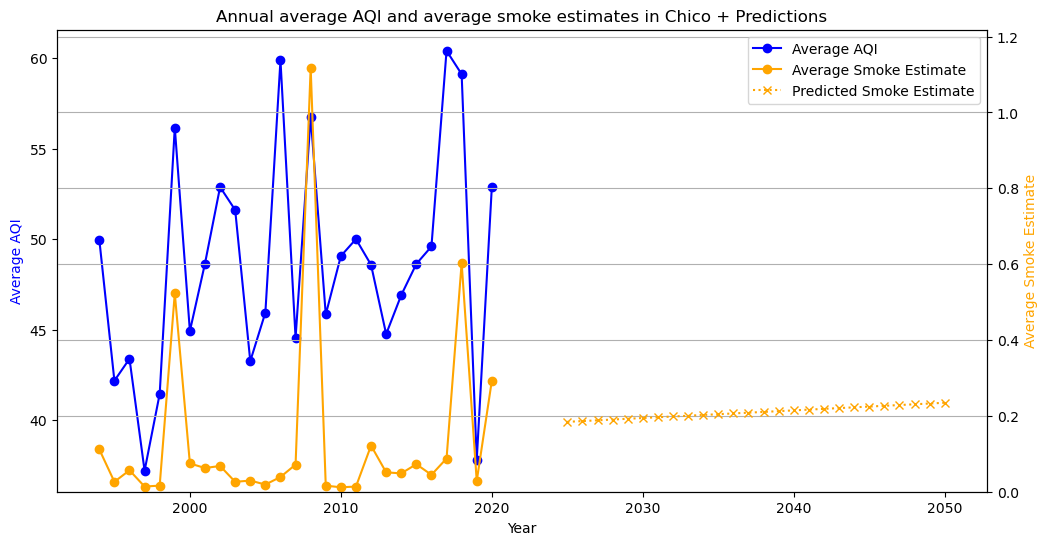

In [72]:
plt.figure(figsize=(12, 6))

aqi_line, = plt.plot(combined_df['year'], combined_df['average_aqi'], marker='o', linestyle='-', label='Average AQI', color='blue')
plt.ylabel('Average AQI', color='blue')
plt.xlabel('Year')

# second y-axis for smoke estimates
ax2 = plt.gca().twinx()
smoke_line, = ax2.plot(combined_df['year'], combined_df['average_smoke_estimate'], marker='o', linestyle='-', label='Average Smoke Estimate', color='orange')
ax2.set_ylabel('Average Smoke Estimate', color='orange') 

future_smoke_line, = ax2.plot(future_years, future_smoke_estimates, marker='x', linestyle=':', label='Predicted Smoke Estimate', color='orange')

plt.ylim(0, max(combined_df['average_aqi'].max(), future_smoke_estimates.max()))
ax2.set_ylim(0, max(combined_df['average_smoke_estimate'].max(), future_smoke_estimates.max())+ 0.1) 

plt.title('Annual average AQI and average smoke estimates in Chico + Predictions')

ax2.legend([aqi_line, smoke_line, future_smoke_line], ['Average AQI', 'Average Smoke Estimate', 'Predicted Smoke Estimate'], loc='upper right')

plt.grid(True)
plt.show()

### Link to [visualizations, figure descriptions, and reflection statement on the collaborative aspects of the assignment.](https://docs.google.com/document/d/12CiPrrHK_P5aG3uOjbt3Qy-Cv1CzFTUMY2aJxEq22ag/edit?usp=sharing)